# hog+svm classify satellite image ships

In [1]:
# linear algebra
import numpy as np 
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

In [6]:
from subprocess import check_output
print(check_output(["dir", "./ships-in-satellite-imagery"]).decode("utf-8"))
# 仅仅适用于Linux系统

FileNotFoundError: [WinError 2] 系统找不到指定的文件。

In [8]:
with open('./ships-in-satellite-imagery/shipsnet.json') as fp:
    dataset = json.load(fp)

dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [11]:
dataset.get('locations')[0:10]

[[-118.2254694333423, 33.73803725920789],
 [-122.33222866289329, 37.7491755586813],
 [-118.14283073363218, 33.736016066914175],
 [-122.34784341495181, 37.76648707436548],
 [-122.34852408322172, 37.75878462398653],
 [-118.16932888763621, 33.734252827962536],
 [-122.35145112805893, 37.75120269950231],
 [-122.35158678931549, 37.74736384875284],
 [-122.34695357410399, 37.73984834452207],
 [-122.34291347769646, 37.75007383360081]]

(4000, 19200)


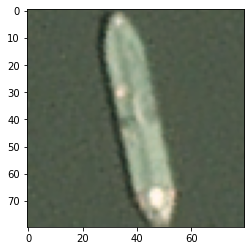

In [12]:
data = np.array(dataset['data']).astype('uint8')
print(data.shape)
img_length = 80
data = data.reshape(-1,3,img_length,img_length).transpose([0,2,3,1])

plt.imshow(data[51])

# 在计算hog特征之前将图像转为灰度图像

(4000, 80, 80, 3)


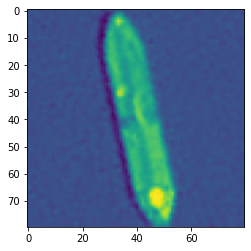

In [14]:
data_gray = [ color.rgb2gray(i) for i in data]
plt.imshow(data_gray[51])
print(data.shape)

HOG分析

In [27]:
ppc = 16
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [28]:
hog?

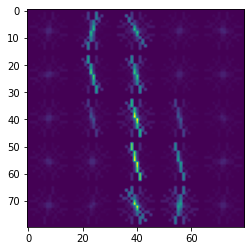

In [29]:
plt.imshow(hog_images[51])

In [30]:
labels =  np.array(dataset['labels']).reshape(len(dataset['labels']),1)

# 构建SVM分类模型

In [31]:
clf = svm.SVC()

hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features,labels))
np.random.shuffle(data_frame)

In [33]:
data_frame

array([[0.03292131, 0.01235779, 0.01520493, ..., 0.37183477, 0.16676101,
        0.        ],
       [0.02739036, 0.02303083, 0.0295598 , ..., 0.01656602, 0.03001119,
        0.        ],
       [0.06580202, 0.04209505, 0.03453138, ..., 0.02331582, 0.02202196,
        1.        ],
       ...,
       [0.12785299, 0.11131424, 0.06152489, ..., 0.04920484, 0.07940843,
        0.        ],
       [0.06568155, 0.04452403, 0.05724757, ..., 0.02415848, 0.03921156,
        0.        ],
       [0.06658263, 0.09913607, 0.07345207, ..., 0.05473308, 0.04978603,
        0.        ]])

In [23]:
#What percentage of data you want to keep for training
percentage = 80
partition = int(len(hog_features)*percentage/100)
partition

In [24]:
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

clf.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
y_pred = clf.predict(x_test)

In [26]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.99875


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       592
         1.0       1.00      1.00      1.00       208

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

